# Small ResNet Network

This notebook implements the small ResNet network diagrammed below and trains and tests it on the MNIST dataset.

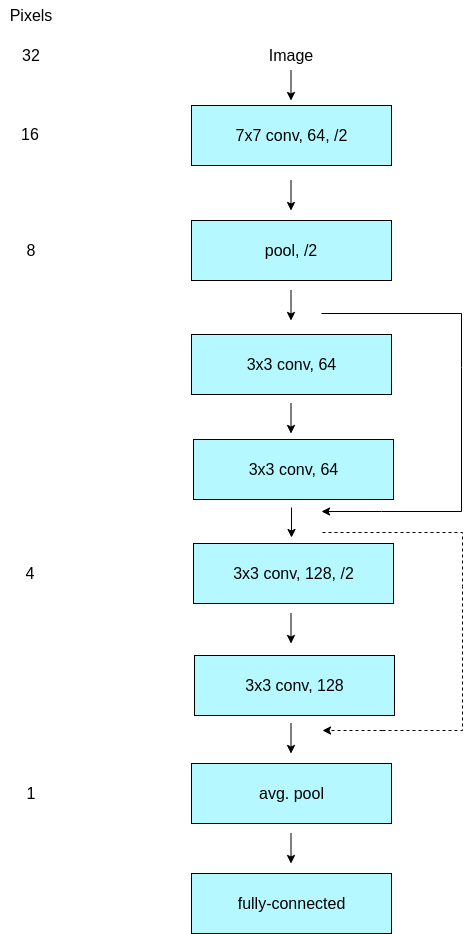

### Imports

In [1]:
# Imports
import torch                     
import torch.nn as nn            
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

### Download Training Data

In [2]:
# Download subset of the MNIST dataset for training
N_TRAINING_IMAGES = 20000
transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor(),transforms.Normalize((0.5), (0.5))])
subset = list(range(0, N_TRAINING_IMAGES))
trainset_total = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainset = torch.utils.data.Subset(trainset_total, subset)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/home/rick/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
print('Number of training images = {}, size of training images = {}x{}, Size of trainloader = {}'
      .format(len(trainset),trainset[0][0].shape[1],trainset[0][0].shape[1], len(trainloader)))

Number of training images = 20000, size of training images = 32x32, Size of trainloader = 5000


### Display Training Data

    1     8     9     9


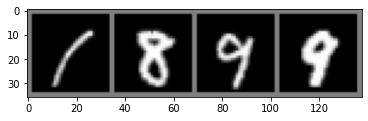

In [6]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Define Network Blocks

In [7]:
# 7x7 convolutional block
class Conv7x7(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv = nn.Conv2d(self.in_channels, self.out_channels, kernel_size=7, stride=2, padding=3)
        self.batch = nn.BatchNorm2d(self.out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.batch(x)
        x = self.relu(x)
        x = self.pool(x)
        return x

In [8]:
# 3x3 convolutional blocks with Skip Connection of Same Dimension
class Conv3x3SkipSame(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv = nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, padding=1)
        self.batch = nn.BatchNorm2d(self.out_channels)
        self.skip = nn.Identity() # For the skip connection
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Skip Connection
        skip = self.batch(self.skip(x))
        # Convolution 1
        x = self.conv(x)
        x = self.batch(x)
        x = self.relu(x)
        # Convolution 2
        x = self.conv(x)
        x = self.batch(x)
        return self.relu(x+skip)

In [9]:
# 3x3 convolutional blocks with Skip Connection of Different Dimension
class Conv3x3SkipDifferent(nn.Module):
    def __init__(self, in_channels_1, out_channels_1, in_channels_2, out_channels_2):
        super().__init__()
        self.in_channels_1 = in_channels_1
        self.out_channels_1 = out_channels_1
        self.in_channels_2 = in_channels_2
        self.out_channels_2 = out_channels_2
        self.conv1 = nn.Conv2d(self.in_channels_1, self.out_channels_1, kernel_size=3, stride=2, padding=1)
        self.batch1 = nn.BatchNorm2d(self.out_channels_1)
        self.conv2 = nn.Conv2d(self.in_channels_2, self.out_channels_2, kernel_size=3, padding=1)
        self.batch2 = nn.BatchNorm2d(self.out_channels_2)
        # Define conv3 for the skip connection
        self.conv3 = nn.Conv2d(self.in_channels_1, self.out_channels_2, kernel_size=1, stride=2)
        self.skip = nn.Identity() # For the skip connection
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=4, stride=1)
        
    def forward(self, x):
        # Skip Connection
        skip = self.batch2(self.skip(self.conv3(x)))
        # Convolution 1
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.relu(x)
        # Convolution 2
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.relu(x+skip)
        x = self.pool(x)
        return x

In [10]:
# Fully-Connected Layer
class FC(nn.Module):
    def __init__(self, n_features, n_classes):
        super().__init__()
        self.n_features = n_features
        self.n_classes = n_classes
        self.linear = nn.Linear(n_features, n_classes)
        self.softmax = nn.Softmax(dim=0)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        x = self.softmax(x)
        return x

### Define ResNet Network

In [11]:
# Define ResNet network
class ResNet(nn.Module):
    # in_channels_list and out_channels_list hold the in and out channel dimensions for the different blocks of the ResNet network
    def __init__(self, in_channels_list, out_channels_list, n_features, n_classes):
        super().__init__()
        self.conv7x7 = Conv7x7(in_channels_list[0], out_channels_list[0])
        self.conv3x3skipsame = Conv3x3SkipSame(in_channels_list[1], out_channels_list[1])
        self.conv3x3skipdifferent = Conv3x3SkipDifferent(in_channels_list[2], out_channels_list[2], in_channels_list[3], out_channels_list[3])
        self.fc = FC(n_features, n_classes)
        
    def forward(self, x):
        x = self.conv7x7(x)
        x = self.conv3x3skipsame(x)
        x = self.conv3x3skipdifferent(x)
        x = self.fc(x)
        return x

### Define Loss, SGD Optimizer, and Instantiate ResNet Object

In [14]:
resnet = ResNet([1,64,64,128], [64,64,128,128], 128, 10)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
# Train on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Train the Network

In [15]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(trainloader):
        # Every data instance is an input + label pair
#         inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device) # train on device
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        
        # Make predictions for this batch
        outputs = resnet(inputs)
        
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        # Adjust learning weights
        optimizer.step()
        
        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
#             tb_x = epoch_index * len(training_loader) + i + 1
#             tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
            
    return last_loss

In [16]:
# Train the network
EPOCHS = 2
epoch_number = 0

# Train on GPU
resnet.to(device)

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    
    # Make sure gradient tracking is on, and do a pass over the data
    resnet.train(True)
    avg_loss = train_one_epoch(epoch_number)
    
    # We don't need gradients on to do reporting
    resnet.train(False)
    print('LOSS train {}'.format(avg_loss))
    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 2.0758548525571823
  batch 2000 loss: 1.843855193257332
  batch 3000 loss: 1.7919525927305222
  batch 4000 loss: 1.7792489175796509
  batch 5000 loss: 1.7710334428548813
LOSS train 1.7710334428548813
EPOCH 2:
  batch 1000 loss: 1.764454645872116
  batch 2000 loss: 1.7621916848421098
  batch 3000 loss: 1.7660565930604935
  batch 4000 loss: 1.7496725215911866
  batch 5000 loss: 1.7525226491689683
LOSS train 1.7525226491689683


### Create Test Set

In [17]:
# Download subset of the MNIST dataset for testing
N_TEST_IMAGES = 1000
transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor(),transforms.Normalize((0.5), (0.5))])
subset = list(range(0, N_TEST_IMAGES))
testset_total = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testset = torch.utils.data.Subset(testset_total, subset)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

In [18]:
print('Number of test images = {}, size of training images = {}x{}, Size of testloader = {}'
      .format(len(testset),testset[0][0].shape[1],testset[0][0].shape[1], len(testloader)))

Number of test images = 1000, size of training images = 32x32, Size of testloader = 250


### Inference Sample Images

pred:7 actual:7 pred:2 actual:2 pred:1 actual:1 pred:0 actual:0


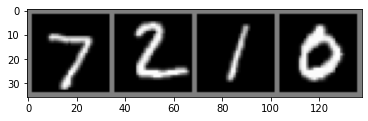

In [27]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# Inference images
images = images.to(device)
output = resnet(images) 
indices = output.detach().cpu().numpy().argmax(axis=1)

# print labels
print(' '.join('%5s %5s' % ('pred:'+str(indices[j]), 'actual:'+str(classes[labels[j]])) for j in range(4)))